In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

2023-11-26 01:45:03.590301: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Diabetic retinopathy, a complication associated with diabetes, affects the eys and can lead to blindness if not diagnosed. This condition results from damage to the blood vessels inside the retina. Diabetic retinopathy is a leading cause of blindness among adult. The goal of this project is to implement a machine learning model that can accurately predict the presence of diabetic retinopathy using retinal images.We will be using the [diabetic retinopathy](https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized/) dataset from kaggle, consisting of 35,108 1024x1024 retinal scans. Below are twelve samples from the dataset.

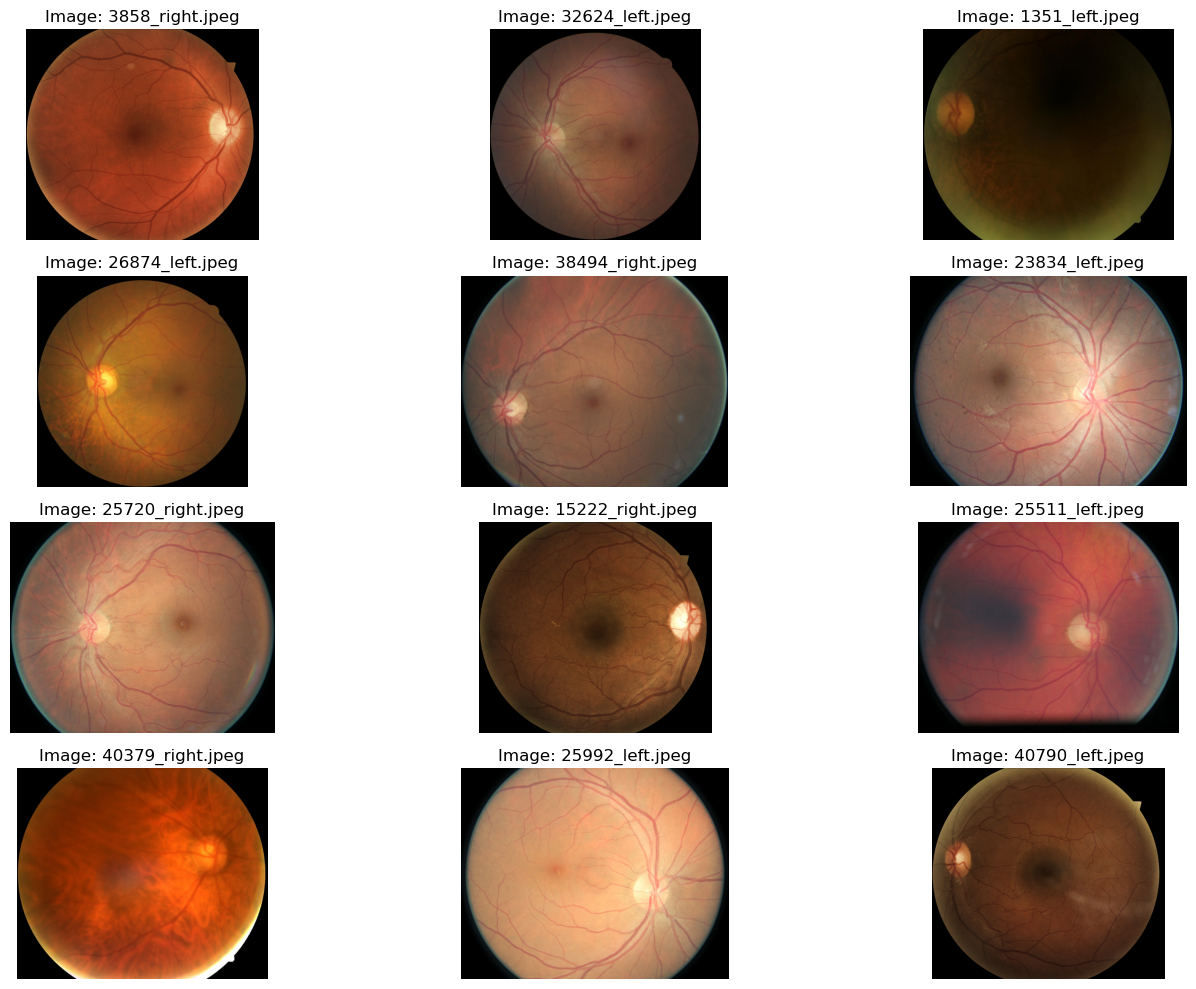

In [2]:
def plot_images(path):
    
    """
    Plots a grid of images from specified directory.
    """
    
    rows = 4
    cols = 3
    
    # fetch list of images
    files = [f for f in os.listdir(path) if f.endswith('.jpeg')]
    
    # select twelve images
    selected = files[:rows * cols]
    
    # create figures with multiple subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < len(selected):
            image_path = os.path.join(path, selected[i])
            image = Image.open(image_path)
            
            ax.imshow(image)
            ax.set_title(f"Image: {selected[i]}")
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

plot_images('./dataset/resized_train_cropped/')

The dataset mentioned above is a *labeled* dataset. This is advantageous for our type of problem, as we will be using supervised learning to classify the severity (if at all) of the diabetic retinopathy. Below are a few commands that summarize the dataset.

In [3]:
labels_df = pd.read_csv('./dataset/trainLabels_cropped.csv')
    
print("Printing head: ")
print(labels_df.head())
    
print("\n Dataset info: ")
labels_df.info()

Printing head: 
   Unnamed: 0.1  Unnamed: 0     image  level
0             0           0   10_left      0
1             1           1  10_right      0
2             2           2   13_left      0
3             3           3  13_right      0
4             4           4   15_left      1

 Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35108 entries, 0 to 35107
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  35108 non-null  int64 
 1   Unnamed: 0    35108 non-null  int64 
 2   image         35108 non-null  object
 3   level         35108 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


The output shows that our dataset does indeed consist of 35,108 images. The csv file contains an 'image' column as well as a 'level' column. The image index specifies the image found in `./dataset/resized_train_cropped/`. Each image has a corresponding level, indicating the severity of diabetic retinopathy in the retinal scan. 

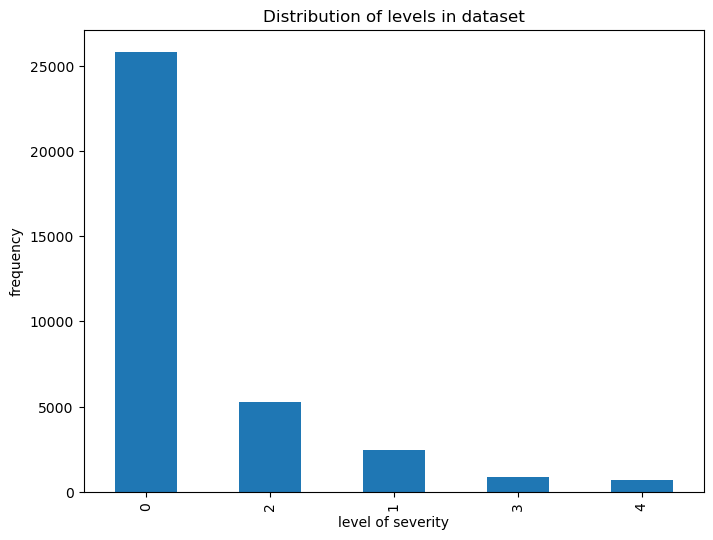

In [4]:
plt.figure(figsize=(8,6))

labels_df['level'].value_counts().plot(kind='bar')

plt.title('Distribution of levels in dataset')

plt.xlabel('level of severity')
plt.ylabel('frequency')
plt.show()

The histogram above depicts the distribution of severity levels within the dataset. The most common classification is level 0, suggesting that majority of the images have no signs of diabetic retinopathy. The remaining images, with increasing severity of the disease, are less frequent. The distribution suggests that mild cases are more common then severe ones.

Below is the `preprocess()` function. The function will be called for every image in the dataset, with the goal of optimizing the image in preparation for the neural network.

The `preprocess()` function resizes each image to 256x256 image, this decreases image size by 16x, making it more managable for the model. 

As seen from the plotted images, each retinal scan is circular. The function crops the image to remove black segments surrounding the retinal scan.

The preprocessing function converts each image into an array of 16 bit floating points and *normalizes* them to values between 0 and 1.

Finally, the function may *augment* each image. Augmentation allows us to artificially increase diversity in a training set.

In [5]:
def preprocess(path, target_size=(256, 256), augment=True):
    
    """
    Process an image via resizing, circular cropping, normalizing and augmenting.
    """
    # resize
    img = Image.open(path).resize(target_size)

    # circular crop
    width, height = img.size
    mask = Image.new('L', (width, height), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse([(0, 0), (width, height)], fill=255)
    img = Image.composite(img, Image.new('RGB', img.size), mask)

    # normalize as 16 bit floating point between 0 and 1
    array = np.array(img).astype(np.float16) / 255

    if augment:
        # augmentation settings
        datagen = ImageDataGenerator(
            rotation_range=10,        # rotation
            width_shift_range=0.1,    # width shift
            height_shift_range=0.1,   # height shift
            shear_range=0.1,          # shear
            zoom_range=0.1,           # zoom
            horizontal_flip=True,     # horizontal flip?
            fill_mode='nearest'
        )
        array = np.expand_dims(array, 0)
        array = next(datagen.flow(array, batch_size=1))[0]

    # ensure no NaN in array (ruins loss function)
    array = np.nan_to_num(array)

    if np.isnan(array).any():
        print(f"Preprocessed image shape: {array.shape}, NaNs present: {np.isnan(array).any()}")

    return array


The `preprocess_generator()` generates batches of preprocessed images and their corresponding labels for training and validation. Batching allows us to divide the dataset into 'chunks' allowing for better memory efficiency (on gpus with lower amounts of vram).

In [6]:
def preprocess_generator(df, batch_size=32):

    # determine total num of samples
    num_samples = len(df)

    while True:
        # iterate over dataset in increments of batch_size
        for offset in range(0, num_samples, batch_size):
            # extract subset of df for current batch
            batch_samples = df.iloc[offset:offset+batch_size]

            images = [] # list of processed images
            labels = [] # list of stored labels

            # process each image in current batch
            for _, row in batch_samples.iterrows():

                # construct image path from the df
                path = os.path.join('./dataset/resized_train_cropped/', f"{row['image']}.jpeg")

                # preprocess image
                img = preprocess(path, augment=False)
                label = row['level']

                # append image
                images.append(img)

                # append/encode labels
                encoded_label = to_categorical(label, 5) # ensure one-hot encoding
                labels.append(encoded_label)

            # convert image/label to numpy array
            X_train = np.array(images)
            y_train = np.array(labels) 

            # return batch of images and labels
            yield X_train, y_train


This project will be using a convolutional neural network. CNNs are common in computer vision related tasks, due to their natural efficiency at processing imagery. 

The initial layer is a Conv2D layer, serving as the intial input layer, `input_shape` being 256x256x3, for a 256x256 image with three color channels. Convolutions act as a sliding window that passes throughought the image. Conv2D layers extract features like edges and gradients, future layers will form more complex patterns from the simpler features extracted by the initial Conv2D layers.

BatchNormalization layers normalize the activations of the Conv2D layer. MaxPooling2D layers reduce the dimensions of the input layer, helping reduce the complexity (therefore the computation necessary).

After two processings of Conv2D, BatchNormalization, and MaxPooling2D, we use a Flatten layer that converts the two dimensional matrix to a vector.

Flattening allows the usage of a Dense layer with 128 neurons. A dense layer is 'fully connected' and is common in traditional neural networks. Dense layers use features learned previously for classifying the input image into one of the five classes (0 to 4).

We also make use of a Dropout layer. Dropout layers randomly ignore a specific portion of neurons before them. This helps prevent overfitting, ensuring that the network does not rely on any singular node.

The finaly layer is another Dense layer with 5 neurons, corresponding to the five classes the model can classify. This layer outputs a probability distribution over the five classes.

In [7]:
def build_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), kernel_initializer=HeNormal()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    model.add(Dense(128, activation='relu', kernel_initializer=HeNormal()))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    return model

We can finally begin to train out model. We start by dividing our training data into training and validation sets using the `train_set_split()` function. 80% of the dataset will be used for training, and 20% will be reserved for validation.

Our model is compiled with a learning rate of 0.00001, a clip value of 0.5 is used to stabilize training. The loss function, categorical cross-entropy, is the standard for multi-class classification tasks.

Training and validation generators are created using the `preprocess_generator()` function defined previously. These generators will supply batches of preprocessed images and corresponding labels to the model during training and validation.

Early stopping is implemented to monitor validation loss and will stop training if their isnt improvement for 10 consecutive epochs.

`TerminateOnNaN` is also implemented to stop training if NaN values are encountered, ensuring numerical stability.

We finally can *fit* our dataset to our model. The number of steps per epoch is determined by dividing the size of the dataset by the batch size.

In [ ]:
printf("Splitting training and validation sets...")
labels_df = pd.read_csv('./dataset/trainLabels_cropped.csv')
train_df, valid_df = train_test_split(labels_df, test_size=0.2)

printf("Building model...")
model = build_model()
model.summary()

printf("Compiling model...")
optimizer = Adam(learning_rate=0.0001, clipvalue=0.5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

printf("Creating training and validation generators...")
train_generator = preprocess_generator(train_df)
valid_generator = preprocess_generator(valid_df)

printf("Initialized early stop, will terminate on NaN")
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
nan_termination = TerminateOnNaN()

printf("Begining training...")

model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // batch_size,
    validation_data=valid_generator,
    validation_steps=len(valid_df) // batch_size,
    epochs=10,
    callbacks=[early_stopping, nan_termination]
)

